In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.constants as cst


In [2]:
import time
start_time = time.time()

In [3]:
#calculating electric field
eps0 = 8.8541878128E-12
k = 1/(4*math.pi*eps0)
print(k)

8987551792.261171


In [4]:
def circular_microwave(t):   #no z dependence
    c = cst.c*1E-10
    lamda = 1E-3 #(set 0.001 to 0.3 m for microwave wavelength)
    power = 10E-3  #10dbm=10mW is standard in ECR paper
    area = math.pi*(2E-2)**2 #2cm radius
    E_0 = np.sqrt(2*power/(eps0*area*c))
    E = [E_0 *math.cos(2*math.pi/lamda*t),E_0 *math.sin(2*math.pi/lamda*t),0]
    freq = c/lamda
    if t%0.2==0: 
        print('freq',freq)
        print('E_0',E_0)
    return E

def circular_microwave_zt(r,t):  #refer to my derivation in paper "Microwave derivation 2"
    z = r[:,2:3]
    
    c = cst.c*1E-10
    lamda = 1E-3 #(set 0.001 to 0.3 m for microwave wavelength)
    power = 10E-3  #10dbm=10mW is standard in ECR paper
    area = math.pi*(2E-2)**2 #2cm radius
    frac = 1/math.sqrt(2)
    E_0 = np.sqrt(power/(2*eps0*area*c))
    Ex = E_0 * (frac + math.sqrt(1 - frac**2))* np.cos(2*math.pi/lamda* (z - c*t))
    Ey = -E_0 * (frac - math.sqrt(1 - frac**2))* np.sin(2*math.pi/lamda* (z - c*t))
    Ez = z*0

    E = np.concatenate((Ex,Ey,Ez),axis=1)
    '''
    freq = c/lamda
    w = circular_microwave_zt_freq()
    if t%0.2==0: 
        print('freq',freq)
        print('microwave_omega', w)
        print('E_0',E_0)   
    '''
    return E

def circular_microwave_zt_freq(lamda = 1E-3):
    #(set lamda 0.001 to 0.3 m for microwave wavelength)
    c = cst.c*1E-10
    freq = c/lamda
    w = 2*math.pi*freq
    return w

This is for seeing the graph of microwave heating

In [5]:
t = 0
micro=[]
time_track=[]

#later, add time frame to insert microwave to heat up plasma
def circular_microwave_graph(t):
    dt = 0.0000001
    t = 0
    E_micro = []
    time = []
    while t <= 0.01:
        #print(t)
        m = circular_microwave(t)
        #print(m)
        E_micro.append(m)
        time.append(t)
        t += dt
    E_microwave = np.array(E_micro)

    plt.subplot(1,2,1)
    plt.plot(time,E_microwave[:,0:1])
    plt.plot(time,E_microwave[:,1:2])
    plt.xlabel("time")
    plt.ylabel("Microwave amplitude")

    plt.subplot(1,2,2)
    plt.plot(E_microwave[:,0:1],E_microwave[:,1:2])
    plt.xlabel("Microwave x")
    plt.ylabel("Microwave y")
    plt.gca().set_aspect('equal')


def microwave_graph(r,T):
    t = 0
    micro=[]
    time=[]

    while t<T:
        micro.append(microwave(r,t))
        time.append(t)
        t += 1E-5
    print('micro size',np.shape(micro))
    #print('micro',micro)
    plt.plot(time,np.array(micro)[:,0])
    plt.show()
    
def circular_microwaveZT_graph(r,T):
    t = 0
    micro=[]
    time=[]

    while t<T:
        micro.append(circular_microwave_zt(r,t))
        time.append(t)
        t += 1E-5
    plt.plot(time,np.array(E_microwave)[:,:,0:1][:,0])
    plt.plot(time,np.array(E_microwave)[:,:,1:2][:,0])
    plt.xlabel("time")
    plt.ylabel("Microwave amplitude")
    plt.show()    
    


This function creates a graph of T vs frequency so that we can observe the microwave heating

In [ ]:
def microwave_heating_graph():
    tau = 10e1000/w_c # tau is the damping decoherence time, tau >> 1/w_c
    k_2 = 10000  #later, in trap potential function k_2 = E_0

    w = np.array([circular_microwave_zt_freq(lamda) for lamda in np.linspace(0.001,0.3,1000)]) #lamda is between 0.001 and 0.3m
    w_z = math.sqrt(q*k_2/m)   
    w_c_prime = w_c - w_z**2/(2*w)
    P_absorbed = (q**2 * tau / m) * E**2/(1+(tau*(w_c_prime - w))**2)
    
    fig, ax = plt.subplots(1,1)
    plt.plot(w,P_absorbed)
    
    return fig

The following is for graphing the energy of the particles. 

In [6]:
#Kinetic Energy vs. time graph
def total_kinetic(m,v):
    return np.sum(1/2*m*v**2)

#Kinetic parallel to B field (assuming B is in z direction only)
def par_kinetic(m,v):
    v_par = v[:,2:3]
    K_par = np.sum(1/2*m*v_par**2)
    return K_par

#Kinetic perpendicular to B field (assuming B is in z direction only)
def perp_kinetic(m,v):
    v_perp = v[:,0:2]
    K_perp = np.sum(1/2*m*v_perp**2)
    return K_perp

def trap_potential(r):
    E_0 = 10000
    r=np.copy(r)
    r[:,0:1],r[:,1:2],r[:,2:3] = 1/4*np.square(r[:,0:1]),1/4*np.square(r[:,1:2]), -1/2*np.square(r[:,2:3])
    U = q*E_0*np.sum(r)
    return U

def interaction_potential(dr_mag_array):
    U = k*q/dr_mag_array
    return U

Calculation of trap potential is done as follows:
E = k*(z -1/2x -1/2y)

In [7]:
def E_trap(r):
    E_0 = 10000
    r=np.copy(r)
    r[:,0:1],r[:,1:2],r[:,2:3] = -1/2*r[:,0:1],-1/2*r[:,1:2],r[:,2:3]
    E= r*E_0
    return r*E_0


In [8]:
q = -1.6E-19 #not sure what to do with the increase in speed and the particle reaching the speed higher than c
m = 9.11E-31
N = 1 # number of particles

mass_array = np.transpose(np.ones(N))*m
mass_array = mass_array[:,None]   #making an array of N x 1
print('mass_array',mass_array)

q_array = np.transpose(np.ones(N))*q
q_array = q_array[:,None]
print('q_array',q_array)

E_ext = np.array([0,0,0])  #needs to be updated according the penning trap potential
B_ext = np.array([0,0,1]) *0.7

#v_array_old = np.array([[10,0,0]])
v_array_old = np.zeros(shape = (N,3)) #for N particles with v = 0
print('v_array_old',v_array_old)

v_array_new = np.zeros(shape = (N,3))

#r_array_old = np.array([[0.00001,0,0],[-0.00001,0,0]])  #for 2 particles
#for 1 particle only:
r_array_old = np.array([[0.0001,0.0001,0.0001]])
print('r_array_old',r_array_old)

r_array_new = np.zeros(shape = (N,3))

mass_array [[9.11e-31]]
q_array [[-1.6e-19]]
v_array_old [[0. 0. 0.]]
r_array_old [[0.0001 0.0001 0.0001]]


In [9]:
#calculating B field
B_array = B_ext
print('B_array = ',B_array)

w_c = q*B_array/m
f_c = np.linalg.norm(w_c/(2*math.pi))
print('ECR freq f_c = ', f_c)
step_max = 1/f_c
if f_c == 0:
    step_max = 1e-10
    print('fc=0')
print('step_max = ', step_max)

B_array =  [0.  0.  0.7]
ECR freq f_c =  19566798711.627087
step_max =  5.1106980489648245e-11


In [10]:
#calculate forces between particles, velocities, and position
from sympy import symbols, Eq, solve, Matrix, linsolve

delta_t = 0.01*step_max
T = 0
Time_max = 5000*step_max #this is the full cyclotron rotation period

dr_array = np.array([np.zeros(shape=(N-1,3)),]*N)
dr_mag_array = np.zeros(shape=(N,1))
E_array = np.array([np.array([0.,0.,0.]) for i in range (N)])   #initialized E_array
#E_array_new = np.array([np.array([0.,0.,0.]) for i in range (N)])

E_track = []
v_track = []
r_track = []
t_track = []
trapU = []
interactionU = []
totalKE = []
parE = []
perpE = []

test_r_final = []  # this list stores final positions after each loop for comparison
test_t_final = []
##print('here0')
while(T<Time_max):#0):#0.5*1/f_c):
    for i in range(N):
        if N == 1:

            break

        r_i = r_array_old[i]
        r_others = np.append(r_array_old[0:i,:],r_array_old[i+1:N,:],axis = 0)  #get rid of the self particle from the array
        dr = -1*(r_others - r_i)
        dr_mag = np.linalg.norm(dr)
        E_others = k*q*dr/(dr_mag**3)
        E_i = E_ext + np.sum(E_others, axis = 0)  #sums up all the E-field from other particles and external E-field
        #store the calculated dr in array of size N
        dr_array[i] = dr
        dr_mag_array[i] = dr_mag
        
        E_array[i] = E_i 
    E_microwave = 0#circular_microwave_zt(r_array_old,T)
    E_array_new = np.copy(E_array)+ np.copy(E_trap(r_array_old)) + E_microwave
    E_track.append(np.copy(E_array)+ np.copy(E_trap(r_array_old)) + E_microwave)

    '''
    if T<1:
        print('E_new',E_array_new)
        print('2 E_array',np.copy(E_array))
        print('Etrap',E_trap(r_array_old))
        print('E_micro',E_microwave)
    '''    
    #At the end of the array, we have as a main thing: E-field whose rows correspond to each particle
    totalKE.append(total_kinetic(m,v_array_old))
    trapU.append(trap_potential(r_array_old))
    if N>1:
        interactionU.append(interaction_potential(dr_mag_array))
    parE.append(par_kinetic(m,v_array_old))
    perpE.append(perp_kinetic(m,v_array_old))
    '''
     if T<1:
        print('E_track',E_track)
        print('E_array for v calc',E_array)   
    '''
    v_minus = v_array_old + delta_t/2*(q_array/mass_array)*E_array_new

    for i in range(N): 
        c = float(-(q_array[i]*delta_t)/(2*mass_array[i]))

        B1= B_array[0]
        B2 = B_array[1]
        B3 = B_array[2]

        a1 = np.array([[1, c*B3, -c*B2], [-c*B3, 1, -c*B1], [c*B2, c*B1, 1]])
        b1 = np.array(-c*np.cross(v_minus[i],B_array) + v_minus[i])
        v_plus =np.linalg.solve(a1, b1)
        
        v_array_new[i] = v_plus + (q_array[i]*delta_t)/(2*mass_array[i])*E_array_new[i]

    r_array_new = v_array_new * delta_t + r_array_old
    #print(r_array_old)
    v_array_old = v_array_new
    r_array_old = r_array_new
    #print(r_array_old)
    v_track.append(np.copy(v_array_old))
    r_track.append(r_array_old)
    t_track.append(T)
    
    T += delta_t



totalKE = np.array(totalKE)
interactionU = np.array(interactionU)

print(interactionU)
print(totalKE[0:10])   
if N == 1:
    print('n==1')
    interactionU = totalKE*0   #just to make an array of same size as totalKE but elements all being 0 for no interaction
print(interactionU[0:10])

intU = [np.linalg.norm(interactionU[i]) for i in range(np.size(totalKE))] 

totalE = np.array(totalKE) + np.array(trapU) + np.array(intU)
totalU = np.array(trapU) + np.array(intU)
trapU = np.array(trapU)
v_track = np.array(v_track)
r_track = np.array(r_track)
t_track = np.array(t_track)
E_track = np.array(E_track)

print('current time = ', time.time()-start_time)

[]
[0.00000000e+00 5.50301298e-33 2.20048221e-32 4.94837667e-32
 8.79038400e-32 1.37214832e-31 1.97352528e-31 2.68238958e-31
 3.49782711e-31 4.41879289e-31]
n==1
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
current time =  87.42315912246704


In [11]:
# print(np.shape(t_track))
# print(np.shape(totalKE))
# print(np.shape(trapU))


In [12]:
print(interactionU[0:10])
print(intU[0:10])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [13]:
#print(E_track)
#%store E_track

In [14]:
#print(v_track)

In [15]:
#print(r_track)

Stored 'r1_track' (ndarray)
Stored 'v1_track' (ndarray)
500001


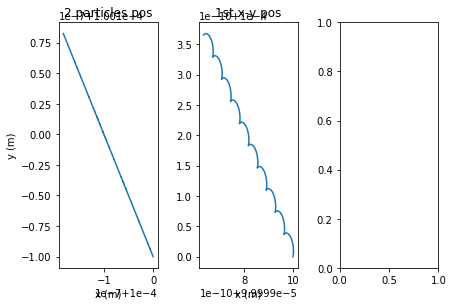

current time =  88.1991319656372


In [16]:
#plotting x vs y position
    
fig, (ax0,ax01,ax02) = plt.subplots(1,3)
fig.tight_layout()

r1_track = r_track[:,0,:]
v1_track = v_track[:,0,:]
%store r1_track
%store v1_track
x1 = r1_track[:,0]
y1 = r1_track[:,1]
size = np.size(y1)
#ax1.margins(-0.1,-0.1)
print(np.size(x1))
#1st particle
#ax01 = plt.subplot(132)
ax0.plot(x1,y1,'-')
ax0.set_xlabel('x (m)')
ax0.set_ylabel('y (m)')
ax0.title.set_text('2 particles pos')

ax01.plot(x1[0:1000],y1[0:1000],'-')
ax01.set_xlabel('x (m)')
ax01.title.set_text('1st x-y pos')
#plt.gca().set_aspect('equal')

if N==2:
    r2_track = r_track[:,1,:]
    v2_track = v_track[:,1,:]
    %store r2_track
    %store v2_track
    x2 = r2_track[:,0]
    y2 = r2_track[:,1]
    ax0.plot(x2,y2)
    ax02.plot(x2[0:1000],y2[0:1000],'-')
    ax02.set_xlabel('x (m)')
    ax02.title.set_text('2nd x-y pos')
   # plt.gca().set_aspect('equal')

plt.show()
    
print('current time = ', time.time()-start_time)

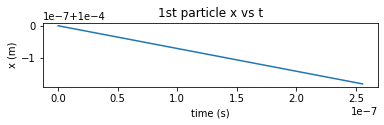

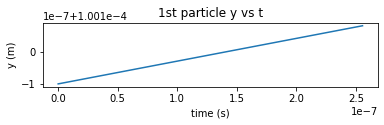

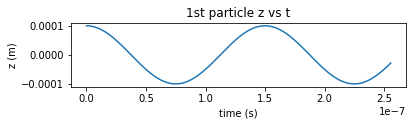

In [17]:
#plotting z vs t
plt.subplot(3,1,1)
x1 = r1_track[:,0]
if N == 2:
    x2 = r2_track[:,0]
plt.xlabel('time (s)')
plt.ylabel('x (m)')
plt.plot(t_track,x1)
plt.title('1st particle x vs t')
plt.show()

#plotting y vs t
plt.subplot(3,1,2)
y1 = r1_track[:,1]
if N == 2:
    y2 = r2_track[:,1]
plt.xlabel('time (s)')
plt.ylabel('y (m)')
plt.plot(t_track,y1)
plt.title('1st particle y vs t')
plt.show()

#plotting z vs t
plt.subplot(3,1,3)
z1 = r1_track[:,2]
if N == 2:
    z2 = r2_track[:,2]
plt.xlabel('time (s)')
plt.ylabel('z (m)')
plt.plot(t_track,z1)
plt.title('1st particle z vs t')
plt.show()

500001


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


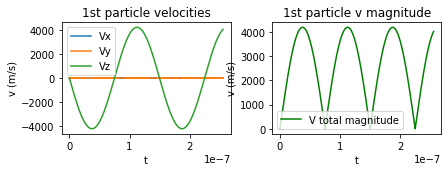

current time =  94.12497210502625


In [18]:
#plotting Vx vs t position
fig1, (ax1,ax11) = plt.subplots(1,2)
fig1.tight_layout()
l = 500001
v1_track = v_track[:,0,:]
vx1 = v1_track[:,0]
vy1 = v1_track[:,1]
vz1 = v1_track[:,2]
print(np.size(vy1))
ax1 = plt.subplot(221)
#ax1.margins(-0.1,-0.1)
Vx_graph, = ax1.plot(t_track[0:l],vx1[0:l],'-',label = 'Vx')
Vy_graph, = ax1.plot(t_track[0:l],vy1[0:l],'-',label = 'Vy')
Vz_graph, = ax1.plot(t_track[0:l],vz1[0:l],'-',label = 'Vz')

plt.xlabel('t')
plt.ylabel('v (m/s)')
ax1.legend(handles=[Vx_graph, Vy_graph,Vz_graph])
plt.title('1st particle velocities')

ax11 = plt.subplot(222)
Vtotal_graph, = ax11.plot(t_track[0:l], np.sqrt(vx1**2 + vy1**2 + vz1**2)[0:l],'g-', label = 'V total magnitude')
plt.xlabel('t')
plt.ylabel('v (m/s)')
ax11.legend(handles=[Vtotal_graph])
plt.title('1st particle v magnitude')
#plt.gca().set_aspect('equal')

#plotting Vy vs t position
if N==2:
    fig2, (ax2,ax22) = plt.subplots(1,2)
    fig2.tight_layout()
    ax2 = plt.subplot(223)
    v2_track = v_track[:,1,:]
    vx2 = v2_track[:,0]
    vy2 = v2_track[:,1]
    print(np.size(vy2))
    plt.title('2nd particle velocities')
    
    #ax2.margins(-0.1,-0.1)
    Vx_graph, = ax2.plot(t_track[0:l],vx2[0:l],'-',label = 'Vx')
    Vy_graph, = ax2.plot(t_track[0:l],vy2[0:l],'-',label = 'Vy')
    plt.xlabel('t')
    plt.ylabel('v (m/s)')
    ax2.legend(handles=[Vx_graph, Vy_graph])
    
    ax22 = plt.subplot(224)
    Vtotal_graph, = ax22.plot(t_track[0:l], np.sqrt(vx2**2 + vy2**2)[0:l],'g-', label = 'V total magnitude')
    plt.xlabel('t')
    plt.ylabel('v (m/s)')
    ax22.legend(handles=[Vtotal_graph])
    plt.title('2nd particle v magnitude')


plt.show()

print('current time = ', time.time()-start_time)

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


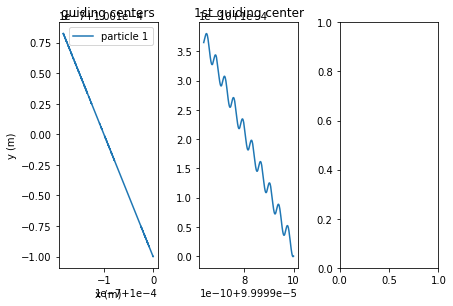

current time =  94.81833505630493


"\nfor plotting R vs t\nax3 = plt.subplot(121)\n#ax1.margins(-0.1,-0.1)\nRx1_graph, = ax3.plot(t_track[0:200],Rx1[0:200],'-',label = 'Rx')\nRy1_graph, = ax3.plot(t_track[0:200],Ry1[0:200],'-',label = 'Ry')\nRz1_graph, = ax3.plot(t_track[0:200],Rz1[0:200],'-',label = 'Rz')\n\nplt.xlabel('t')\nplt.ylabel('position (m)')\nax3.legend(handles=[Rx1_graph, Ry1_graph,Rz1_graph])\nplt.title('1st particle guiding center')\n#plt.gca().set_aspect('equal')\n\n#plotting Vy vs t position\nif N==2:\n    Rx2 = x2 - vy2/np.linalg.norm(w_c)\n    Ry2 = y2 - vx2/np.linalg.norm(w_c)\n    Rz2 = z2\n    ax4 = plt.subplot(122)\n    plt.title('2nd particle guiding center')\n    \n    #ax2.margins(-0.1,-0.1)\n    Rx2_graph, = ax4.plot(t_track[0:200],Rx2[0:200],'-',label = 'Rx')\n    Ry2_graph, = ax4.plot(t_track[0:200],Ry2[0:200],'-',label = 'Ry')\n    Rz2_graph, = ax3.plot(t_track[0:200],Rz2[0:200],'-',label = 'Rz')\n    plt.xlabel('t')\n    #plt.ylabel('position (m)')\n    ax4.legend(handles=[Rx2_graph, Ry2_gr

In [19]:
#plotting guiding center
fig3, (ax3,ax4,ax5) = plt.subplots(1,3)
fig3.tight_layout()
    
if np.linalg.norm(w_c) == 0:
    w_c = 1e-10
Rx1 = x1 - vy1/np.linalg.norm(w_c)
Ry1 = y1 - vx1/np.linalg.norm(w_c)
Rz1 = z1

ax3 = plt.subplot(131)
ax4 = plt.subplot(132)
#ax1.margins(-0.1,-0.1)
R1_graph, = ax3.plot(Rx1,Ry1,label = 'particle 1')
ax4.plot(Rx1[0:1000],Ry1[0:1000])
ax4.title.set_text('1st guiding center')

ax3.set_xlabel('x (m)')
ax3.set_ylabel('y (m)')
ax3.legend(handles=[R1_graph])
ax3.title.set_text('guiding centers')
#plt.gca().set_aspect('equal')

#plotting Vy vs t position
if N==2:
    Rx2 = x2 - vy2/np.linalg.norm(w_c)
    Ry2 = y2 - vx2/np.linalg.norm(w_c)
    Rz2 = z2
    ax5 = plt.subplot(133)
    ax5.title.set_text('2nd guiding center')
    
    #ax2.margins(-0.1,-0.1)
    R2_graph, = ax3.plot(Rx2,Ry2,label = 'particle 2')
    ax5.plot(Rx2[0:1000],Ry2[0:1000])
    ax5.set_xlabel('x (m)')
    #plt.ylabel('position (m)')
    ax3.legend(handles=[R2_graph])
    
plt.show()

print('current time = ', time.time()-start_time)
'''
for plotting R vs t
ax3 = plt.subplot(121)
#ax1.margins(-0.1,-0.1)
Rx1_graph, = ax3.plot(t_track[0:200],Rx1[0:200],'-',label = 'Rx')
Ry1_graph, = ax3.plot(t_track[0:200],Ry1[0:200],'-',label = 'Ry')
Rz1_graph, = ax3.plot(t_track[0:200],Rz1[0:200],'-',label = 'Rz')

plt.xlabel('t')
plt.ylabel('position (m)')
ax3.legend(handles=[Rx1_graph, Ry1_graph,Rz1_graph])
plt.title('1st particle guiding center')
#plt.gca().set_aspect('equal')

#plotting Vy vs t position
if N==2:
    Rx2 = x2 - vy2/np.linalg.norm(w_c)
    Ry2 = y2 - vx2/np.linalg.norm(w_c)
    Rz2 = z2
    ax4 = plt.subplot(122)
    plt.title('2nd particle guiding center')
    
    #ax2.margins(-0.1,-0.1)
    Rx2_graph, = ax4.plot(t_track[0:200],Rx2[0:200],'-',label = 'Rx')
    Ry2_graph, = ax4.plot(t_track[0:200],Ry2[0:200],'-',label = 'Ry')
    Rz2_graph, = ax3.plot(t_track[0:200],Rz2[0:200],'-',label = 'Rz')
    plt.xlabel('t')
    #plt.ylabel('position (m)')
    ax4.legend(handles=[Rx2_graph, Ry2_graph, Rz2_graph])
    
plt.show()

print('current time = ', time.time()-start_time)
'''

Stored 'r1_track' (ndarray)
Stored 'v1_track' (ndarray)
current time =  95.16497778892517


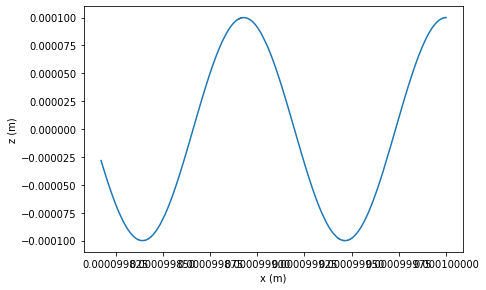

In [20]:
#plotting x vs z position
fig2, ax = plt.subplots()
fig2.tight_layout()
r1_track = r_track[:,0,:]
v1_track = v_track[:,0,:]
%store r1_track
%store v1_track
x1 = r1_track[:,0]
z1 = r1_track[:,2]

ax.set_xlabel('x (m)')
ax.set_ylabel('z (m)')
#plt.gca().set_aspect('equal')
ax.plot(x1,z1)

# plt.subplot(1,3,2)
# if N==2:
#     r2_track = r_track[:,1,:]
#     v2_track = v_track[:,1,:]
#     %store r2_track
#     %store v2_track
#     x2 = r2_track[:,0]
#     z2 = r2_track[:,2]
#     plt.plot(x2,z2)
#     plt.xlabel('x (m)')
#     plt.ylabel('z (m)')
#     #plt.gca().set_aspect('equal')
#     plt.show()



print('current time = ', time.time()-start_time)

Stored 'E_1' (ndarray)


"\nplt.subplot(1,3,2)\nplt.xlabel('t (s)')\nplt.ylabel('Ey')\nplt.title('Ey')\nplt.plot(t_track,E_1[:,1])\nif N==2:\n    plt.plot(t_track,E_2[:,0])\n#plt.plot(t_track,E_2[:,0])\n#plt.plot(t_track,E_1[:,1])\n#plt.plot(t_track,E_1[:,2])\n"

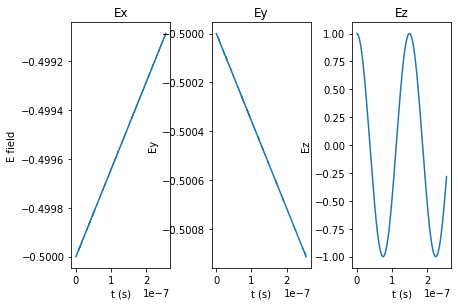

In [21]:
#plotting E_array vs t 
E_1 = E_track[:,0,:]
%store E_1
if N==2:
    E_2 = E_track[:,1,:]
    %store E_2
    
fig1, axs = plt.subplots(1,3)
fig1.tight_layout()

axs[0].set_xlabel('t (s)')
axs[0].set_ylabel('E field')
axs[0].set_title('Ex')
#plt.gca().set_aspect('equal')
axs[0].plot(t_track,E_1[:,0])

axs[1].set_xlabel('t (s)')
axs[1].set_ylabel('Ey')
axs[1].set_title('Ey')
axs[1].plot(t_track,E_1[:,1])

axs[2].set_xlabel('t (s)')
axs[2].set_ylabel('Ez')
axs[2].set_title('Ez')
axs[2].plot(t_track,E_1[:,2])

if N==2:
    plt.plot(t_track,E_2[:,0])

'''
plt.subplot(1,3,2)
plt.xlabel('t (s)')
plt.ylabel('Ey')
plt.title('Ey')
plt.plot(t_track,E_1[:,1])
if N==2:
    plt.plot(t_track,E_2[:,0])
#plt.plot(t_track,E_2[:,0])
#plt.plot(t_track,E_1[:,1])
#plt.plot(t_track,E_1[:,2])
'''


This plots kinetic energies

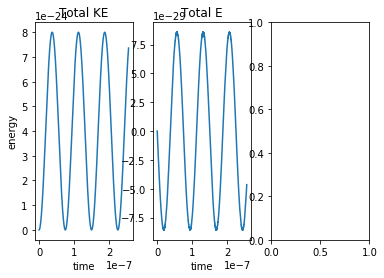

In [23]:
from operator import add

plt.subplot(131)
plt.plot(t_track,totalKE)
plt.ylabel('energy')
plt.title('Total KE')
plt.xlabel('time')
plt.subplot(132)
plt.plot(t_track,totalE)
plt.title('Total E')
plt.xlabel('time')
plt.subplot(133)


Text(0.5, 0, 'time')

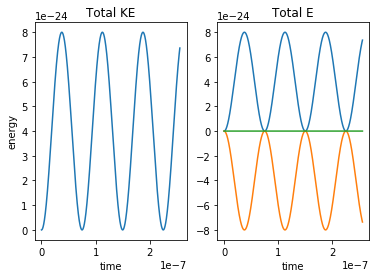

In [24]:
plt.subplot(121)
l = 500001
plt.plot(t_track[0:l],totalKE[0:l])
plt.ylabel('energy')
plt.title('Total KE')
plt.xlabel('time')


plt.subplot(122)
plt.plot(t_track[0:l],totalKE[0:l])
plt.plot(t_track[0:l],trapU[0:l])
plt.plot(t_track[0:l],totalE[0:l])
plt.title('Total E')
plt.xlabel('time')



Text(0.5, 1.0, '1st total energy')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


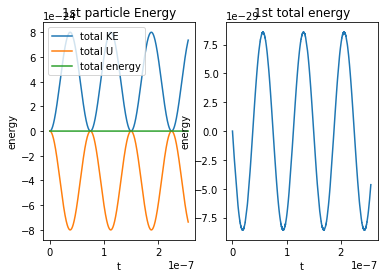

In [25]:
#plotting total energy
fig_energy, (ax_energy1, ax_energy2) = plt.subplots(1,2)

l = 500001
ax_energy1 = plt.subplot(121)
totalKE_graph, = ax_energy1.plot(t_track[0:l],totalKE[0:l],'-',label = 'total KE')
totalU_graph, = ax_energy1.plot(t_track[0:l],totalU[0:l],'-',label = 'total U')
totalE_graph, = ax_energy1.plot(t_track[0:l],totalE[0:l],'-',label = 'total energy')

plt.xlabel('t')
plt.ylabel('energy')
ax_energy1.legend(handles=[totalKE_graph, totalU_graph, totalE_graph])
plt.title('1st particle Energy')

ax_energy2 = plt.subplot(122)
plt.plot(t_track[0:l],totalE[0:l],'-',label = 'total energy')
plt.xlabel('t')
plt.ylabel('energy')
plt.title('1st total energy')

Text(0.5, 0, 't')

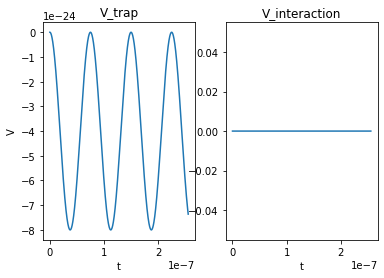

In [26]:
#plotting potentials
plt.subplot(121)
plt.title('V_trap')
plt.plot(t_track,np.array(trapU))
plt.xlabel('t')
plt.ylabel('V')

plt.subplot(122)
plt.title('V_interaction')
plt.plot(t_track,np.array(intU))
plt.xlabel('t')



Text(0.5, 0, 't')

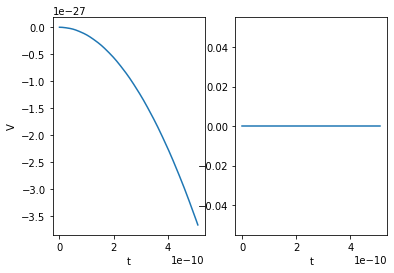

In [27]:
#plotting potentials
plt.subplot(121)
#plt.title('V_trap')
plt.plot(t_track[0:1000],np.array(trapU)[0:1000])
plt.xlabel('t')
plt.ylabel('V')

plt.subplot(122)
#plt.title('V_interaction')
plt.plot(t_track[0:1000],np.array(intU)[0:1000])
plt.xlabel('t')


In [28]:
#testing the final positions of the particle after each loop
'''
import statistics
x = np.array(test_r_final)[:,:,0]
y = np.array(test_r_final)[:,:,1]
z = np.array(test_r_final)[:,:,2]
t = test_t_final
print('r',test_r_final)
print('time',test_t_final)
plt.subplot(1,2,1)
plt.scatter(x,y)
plt.xlabel('x (m)')
plt.ylabel('y (m)')

plt.subplot(1,2,2)
plt.scatter(t,z)
plt.xlabel('t (s)')
plt.ylabel('z (m)')
print(np.std(x),np.std(y),np.std(z))
'''

"\nimport statistics\nx = np.array(test_r_final)[:,:,0]\ny = np.array(test_r_final)[:,:,1]\nz = np.array(test_r_final)[:,:,2]\nt = test_t_final\nprint('r',test_r_final)\nprint('time',test_t_final)\nplt.subplot(1,2,1)\nplt.scatter(x,y)\nplt.xlabel('x (m)')\nplt.ylabel('y (m)')\n\nplt.subplot(1,2,2)\nplt.scatter(t,z)\nplt.xlabel('t (s)')\nplt.ylabel('z (m)')\nprint(np.std(x),np.std(y),np.std(z))\n"